In [25]:
import torch.nn as nn
import torchvision.models as models
import torch
import pandas as pd
import torch.optim as optim 
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
new_model = models.inception_v3(pretrained=True, aux_logits=False)
new_model.fc

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


Linear(in_features=2048, out_features=1000, bias=True)

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size) #map to embed size then send to RNN
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0) # dimension for the batch
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)  # word that has highest probability
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [5]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

In [6]:
spacy_eng = spacy.load("en_core_web_sm")

In [7]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [8]:
annotation = pandas.read_csv("/content/drive/My Drive/flickr8k/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [9]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [10]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="/content/drive/My Drive/flickr8k/images", caption_path="/content/drive/My Drive/flickr8k/captions.txt", transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_path)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [11]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [18]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [19]:
def save_checkpoint(state, filename = "/content/drive/My Drive/my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [20]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [18]:
train_loader, dataset = get_loader(
        root_dir="/content/drive/My Drive/flickr8k/images",
        caption_path="/content/drive/My Drive/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([   1,    4,   80,    8,    4,   21,   83,   16,  350,  141,   75,    8,
           4, 2239,    5,    2])
<SOS> a woman in a white shirt and dark jacket stands in a marsh . <EOS> 

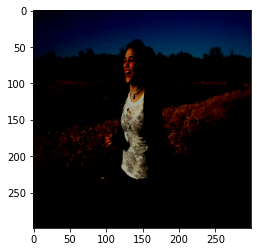

In [20]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [13]:
from torch.utils.tensorboard import SummaryWriter

In [14]:
writer = SummaryWriter("/content/drive/My Drive/runs/flickr")
step = 0

In [15]:
import torch
import torchvision.transforms as transforms
from PIL import Image


def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open("/content/drive/My Drive/test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )
    test_img2 = transform(
        Image.open("/content/drive/My Drive/test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )
    test_img3 = transform(Image.open("/content/drive/My Drive/test_examples/bus.png").convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )
    test_img4 = transform(
        Image.open("/content/drive/My Drive/test_examples/boat.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )
    test_img5 = transform(
        Image.open("/content/drive/My Drive/test_examples/horse.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()


In [21]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="/content/drive/My Drive/flickr8k/images",
        annotation_file="/content/drive/My Drive/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = False
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 100

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        print(f"Loss for epoch {epoch}: {loss}")

In [ ]:
train()

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: benches built rowboat unfinished motorcyclists trick handles skyline good claus runners female ladder few sand leads sprayed bulldog observing goat spout peanut swings sandy pyramid starting training starting funny seal seal seal played soda cowboy bottle overlooks resort carries hold hides cutting ninja college surrounding opening garden incline incline built
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: benches built rowboat unfinished motorcyclists trick handles skyline good claus runners female ladder few sand leads sprayed bulldog observing goat spout peanut swings sandy pyramid starting training starting funny seal seal seal played soda cowboy bottle overlooks resort carries hold hides cutting ninja college surrounding opening garden incline incline built
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: entrance tripod fence front camel lasso pooh pick blindfolded backdrop pa

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is jumping on a <UNK> . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is jumping on a <UNK> . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is jumping on a <UNK> . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is jumping on a <UNK> . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is jumping on a <UNK> . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing in a field . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing in a field . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing in a field . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing in a field . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing in a field . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt and a black shirt is standing on a bench . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and a black shirt and a black shirt is standing in the snow . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black shirt and a black shirt and a black and white shirt is standing in the snow . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a blue shirt is jumping into a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and a black hat and a red hat is standing in front of a crowd . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a rock . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young girl in a pink shirt is playing with a ball in a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a white shirt and a black hat is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike in the air . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the snow . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is jumping into the air . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is riding a bike in the air . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through the grass . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young boy in a blue shirt and a blue shirt is jumping into a pool . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt and a black hat is standing in front of a building . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is jumping in the air . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is jumping over a hurdle . <EOS>


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the grass . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young girl in a pink shirt is running through a field of grass . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is surfing a wave . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man is standing in the snow with a dog . <EOS>


  0%|          | 1/1265 [00:00<16:34,  1.27it/s]